In [1]:
!pip install simpy


In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#SIMULATOR CODE
def patient_process(env, doctors, service_rate, wait_times):
    arrival_time = env.now
    with doctors.request() as request:
        yield request
        wait_times.append(env.now - arrival_time)
        service_time = random.expovariate(service_rate)
        yield env.timeout(service_time)

def run_hospital_simulation(arrival_rate, service_rate, num_doctors, sim_time=100):
    env = simpy.Environment()
    doctors = simpy.Resource(env, capacity=num_doctors)
    wait_times = []

    def arrivals(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(patient_process(env, doctors, service_rate, wait_times))

    env.process(arrivals(env))
    env.run(until=sim_time)

    return np.mean(wait_times) if wait_times else 0


In [4]:
#SINGLE TEST RUN
run_hospital_simulation(
    arrival_rate=5,
    service_rate=8,
    num_doctors=3
)


np.float64(0.0007017735351414583)

In [5]:
#GENERATING 1000 SIMULATIONS
data = []

for _ in range(1000):
    arrival_rate = random.uniform(1, 10)
    service_rate = random.uniform(2, 12)
    doctors = random.randint(1, 5)

    avg_wait = run_hospital_simulation(
        arrival_rate, service_rate, doctors
    )

    data.append([arrival_rate, service_rate, doctors, avg_wait])

df = pd.DataFrame(
    data,
    columns=["arrival_rate", "service_rate", "doctors", "avg_wait_time"]
)

df.head()


,arrival_rate,service_rate,doctors,avg_wait_time
0,1.133250,2.417003,1,0.834358
1,2.762431,7.741053,1,0.055897
2,7.316189,11.135437,1,0.174616
3,7.741069,8.000392,2,0.031770
4,8.192509,8.644379,5,0.000014


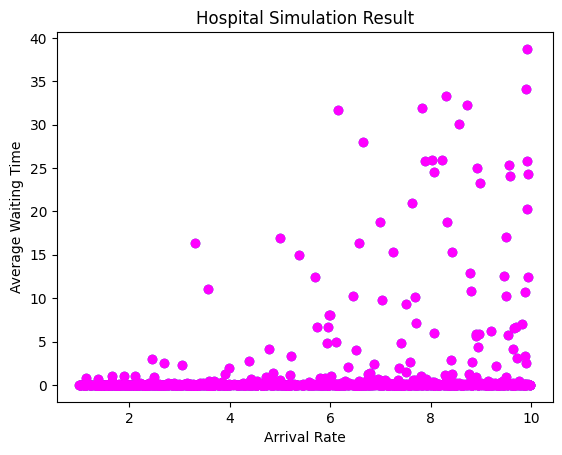

In [8]:
plt.scatter(df["arrival_rate"], df["avg_wait_time"])
plt.xlabel("Arrival Rate")
plt.ylabel("Average Waiting Time")
plt.title("Hospital Simulation Result")
plt.scatter(df["arrival_rate"], df["avg_wait_time"], color="magenta")
plt.show()


In [9]:
# ML MODELS COMPARISON
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


In [10]:
X = df[["arrival_rate", "service_rate", "doctors"]]
y = df["avg_wait_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append([
        name,
        mean_squared_error(y_test, preds),
        r2_score(y_test, preds)
    ])

results_df = pd.DataFrame(
    results,
    columns=["Model", "MSE", "R2 Score"]
)

results_df.sort_values(by="R2 Score", ascending=False)


,Model,MSE,R2 Score
5,KNN,2.224480,0.902051
2,Random Forest,3.114131,0.862877
3,Gradient Boosting,4.315407,0.809982
1,Decision Tree,4.463945,0.803441
0,Linear Regression,17.092382,0.247380
4,SVR,17.435557,0.232269


In [11]:
df.to_csv("simulation_data.csv", index=False)
